In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt') 
from IPython.display import clear_output


from API_Reddit.comments_extractor import comments_extractor
from TextAnalysis.preprocessor import TextPreprocessor
from TextAnalysis.descriptive_statistics_and_visalization import word_length_distribution, calculate_word_statistics, plot_most_frequent_words
from TextAnalysis.words_replacing import WordReplacer
from TextAnalysis.stem_and_lem  import TextStemLem
from TextAnalysis.pre_prepocessing import hash_text, change_time_format
from TextAnalysis.word_mapping import word_mapping
from TextAnalysis.sentiment_analysis_over_time import analyze_sentiment
from TextAnalysis.word_embedding import create_word_embeddings

clear_output()

Note: there might be some problems with the importing some libraries (like gensim) to the terminal and then running the import in the Jupyter notebook. If you cannot import them and Python says about unresolved imports, try this:
```py
!python -m pip install -U gensim
```
Just put in the cell of the Jupyter Notebook, install an restart everything.

---

# Exctraction of comments using Reddit API

In [ ]:
# Two distinct dataframes are created. It takes a few minute to extract all comments, 
# so consider making tea in the meantime

comments_after_win = comments_extractor('ACMilan', '17pzwvv') 
comments_after_lose = comments_extractor('ACMilan', '17gb1xz')

 If you do not want to waste your time running the code over and over again to download comments aftere there is so mistake, consider downloading data to a csv file and name it the way you like. After that just assign in to a variable. For example:

```py
comments_after_lose.to_csv('milan_lost.csv', index=False)
sad_comments = pd.read_csv('milan_lost.csv')
```

I will continue with the previous names of the dataframe.

In [2]:
comments_after_lose = pd.read_csv('milan_lost.csv')
comments_after_win = pd.read_csv('milan_win.csv')

You can check that everything is ok just by writing the name(s) of a DataFrame and running the code. Before that, however, I want to apply two functions that allow me to present the better version of the data:
- I want to hash the names of people leaving commets
- change the date_time representation so that it is more user-friendly

To do so, I use functions from the "pre_preprocessing" module from the TextAnalysis Folder.

In [3]:
# Firstly I hash the 'author' columns in both dataframes
comments_after_win = hash_text(comments_after_win,column_name='author')
comments_after_lose = hash_text(comments_after_lose,column_name='author')

# Then I change the format of the representation of date and time
comments_after_win = change_time_format(comments_after_win,column_name='created_utc')
comments_after_lose = change_time_format(comments_after_lose,column_name='created_utc')

#Lastly, to each of the dataframes I add a column with the results of the match: win or lose
comments_after_win['match_status'] = 'win'
comments_after_lose['match_status'] = 'lose'
# It will be needed for word embedding,

---

### The DataFrames afrer pre_prepocessing:

In [ ]:
comments_after_lose.head(5)

In [ ]:
comments_after_win.head(5)

---

# Preprocessing Stage

#### Now we use quite a few function to preprocess data
Consult with the "preprocessor", "words_replacing"and "stem_and_lem" modules in the TextAnalysis folder. All the documentation is written there.

After the execution of the comments we expect the text to be:
- In lower case;
- Without any links;
- Without punctuation;
- Without stopwords (words that don't have much meaning);
- Without any special characters;
- Contaning only words with more than 2 letters (to avoid nonsense words that might appear during previous stages);
- With curse words masked;
  
Additionally, I manually replace some of the words as long as they refer to the same thing(person) but are treated differently when analyzing data. Mainly, it concerns surnames of the players. For example, Christian Pulisic can be addressed by "Puli" and "Pulisich" by the fans of Milan; or "RCL" is a "Ruben Loftus-Cheek". No python library can trace it, so I have to manually change it if I notice something. It can surely impact the analysis of the comments, but there is no recearch withou limitations.  For that, I use "words_replacing" module in the TextAnalysis folder.

Lastly, I want to add two columns to the dataframe: one with stemmed words and another with lemmatized words. Those are nedded as I want to compare text of I receive after preprocessing with even "purer" data to have just a better view of the situation. For that, I use "stem_and_lem" module in the TextAnalysis folder.

We have to make instances of the class TextProcessor to apply all the functions:

In [4]:
preprocessor_lose = TextPreprocessor(comments_after_lose)
preprocessor_win = TextPreprocessor(comments_after_win)

After that we create dataframes out of the instances:

In [5]:
# body -- the name of the column that contains the text of the comments
preprocessed_lose_df = preprocessor_lose.apply_all('body')
preprocessed_win_df = preprocessor_win.apply_all('body')

Now we can look what we get:

In [ ]:
preprocessed_lose_df.head(5)

In [ ]:
preprocessed_win_df.head(5)

Now let's turn to the replacement of the word that refer to the same person:

In [6]:
# We firstly create two instances of the WordReplacer class
word_replacer_win = WordReplacer(preprocessed_win_df)
word_replacer_lose = WordReplacer(preprocessed_lose_df)

#Then we create two dataframes (I name them the same way to avoid the confusion)
# and we use the dictionary 'word_mapping' from the respective module.
preprocessed_win_df = word_replacer_win.replace_words('body', word_mapping)
word_replacer_lose = word_replacer_lose.replace_words('body', word_mapping)

In [ ]:
preprocessed_win_df.head(5) #It works, as we have "leao" instead of "rafa".

##### Now we can proceede with adding columns with stemmed and lemmatized words:

In [7]:
# We firstly create two instances of the TextStemLem class:
tsl_w = TextStemLem(preprocessed_win_df)
tsl_l = TextStemLem(preprocessed_lose_df)

# Then we add a column with stemmed words
tsl_w.stem_words('body')
tsl_l.stem_words('body')

# Finally, we add a column with lemmatized words
tsl_w.lemmatize_words('body')
tsl_l.lemmatize_words('body')

clear_output()

In [8]:
preprocessed_win_df = tsl_w.dataframe
preprocessed_lose_df = tsl_l.dataframe

In [ ]:
preprocessed_win_df.head(5) # As you can see, everything works
# and we are done with the preprocessing part

---

# Descriptive Statistics

To get the descriptive statistics, I use functions from the "descriptive_statistics" module in the TextAnalysis folder.
There are three functions:

1) word_length_distribution: It returns histograms with the distribution of words in columns
2) calculate_word_statistics: It returns a DataFrame with the statistics about the words (total number of words, number of unique words, average length, median word lenght)
3) plot_most_frequent_words: It returns histograms with the most frequently used words (number is arbitrary, by default it is 10

As long as I apply this function to the columns 'body', 'stemmed_words', and 'lemmatized_words', there should be a list of them to apply functions simultanitously. 

In [9]:
# create a list with column names 
columns_list = ['body', 'stemmed_words', 'lemmatized_words']

Let's see at the histogram with the words' length distribution:

In [ ]:
word_length_distribution(preprocessed_win_df, columns_list,figsize=(5,8))

In [ ]:
word_length_distribution(preprocessed_lose_df, columns_list,figsize=(5,8))

Then let's see at the descriptive statistics concerning the words usage:

In [ ]:
calculate_word_statistics(preprocessed_win_df, columns_list)

Lastly, lets see at the most used words in the comments after the both games:

In [ ]:
plot_most_frequent_words(preprocessed_lose_df,columns_list)

In [ ]:
plot_most_frequent_words(preprocessed_win_df,columns_list, 10)

What we can see from these histograms:
1. When Milan lost, fans blamed Krunić (a player of Milan that played badly) and Pioli (the coach of Milan; he also frequently pick Krunić for the main squad, causing negative sentiment often).
2. We also see that they adressed  Leao and the team in general in their comments (blaming it as a whole).
3. When Milan won, they praised Ruben Loftus-Cheek, Pulisic and Leao.
4. They also addres the coach of Milan (from the actual text fans mostly joke about his love to use Krunić in every game, strategy and another match when he saved himself from being fired).

---

# Sentiment Analysis

Now we proceede with the sentiment analysis. Consult with the 'sentiment_analysis_over_time' module.

In [ ]:
# In the function we are going to use, we need to insert the date of the match. I prefer to create a variable for that, 
# but you can directly insert the dates it is written here. Note that you have to insert either of those dates, and the time: 20 and 23.
# If not, the graph will not appear as intended (see it yourself in the title of the graph).
the_day_milan_lost = '2023-10-25'
the_day_milan_won = '2023-11-07'

In [ ]:
# Assuming your DataFrame is named 'preprocessed_win_df'
# Replace 'YourColumnName' with the actual column names in your DataFrame

# Use the function with your specific parameters
analyze_sentiment(preprocessed_win_df, the_day_milan_won, 20, 23, interval_minutes=5)

In [ ]:
analyze_sentiment(preprocessed_lose_df, the_day_milan_lost, 20, 23, interval_minutes=5)

In most of the cases, sentiment is neutral (interval for that is from -0.5 and 0.5). Interesting that there is a spike in the 'positivity' (even though it is not positive as it does not near 0.5) after the match has finished (probably fans could not believe in that and were able to write something good on Reddit only one hour after the game finished).

---

# Word Embedding

## DISCLAIMER:
The model I am to build to predict ...
There are quite a few problems related to my particular case
1) I use comments to only 2 games, which is definetely not enough to build more or less useful moder
2) I use reddit commets (well, you can see how people talk on reddit, their comments rarely make sense. So the source of data is also important to consider).
3) I do not use games that resulted in a draw 

And so on...

Even though I realize te presence of the problems, I anyway created the model for fun (and to demonstrate that I can copy YouTube tutorials on word embedding). Have fun!

Lets firstly concatinate the two dataframes:

In [9]:
concatenated_df = pd.concat([preprocessed_win_df, preprocessed_lose_df], axis=0, ignore_index=True)

In [10]:
concatenated_df.head(5)

,author,body,created_datetime,match_status,stemmed_words,lemmatized_words
0,e747f9104e,match thread todays match testing new feature ...,2023-11-07 17:47:32,win,match thread today match test new featur reddi...,match thread today match testing new feature r...
1,c781e57654,rlc different type animal today holy sh****,2023-11-07 22:02:38,win,rlc differ type anim today holi sh****,rlc different type animal today holy sh****
2,b7aa5347ca,leao world class tonight running like crazy,2023-11-07 21:42:52,win,leao world class tonight run like crazi,leao world class tonight running like crazy
3,e52216b2a4,rlc signing summer confirmed,2023-11-07 20:51:49,win,rlc sign summer confirm,rlc signing summer confirmed
4,439667f389,calabria pocketing superstar,2023-11-07 21:59:58,win,calabria pocket superstar,calabria pocketing superstar


Then we apply function called 'create_word_embeddings' from the 'word_embedding' module. In the arguments you should write the column you want to have embedded words from. Actually, as the future analysis shows, it does not matter if you indicate 'body', 'stemmed_words', or 'lemmatized_words' in the argument. The model accuracy is the same (and pretty low).

In [12]:
create_word_embeddings(concatenated_df,'body')

,author,body,created_datetime,match_status,stemmed_words,lemmatized_words,tokenized_comments,comment_embeddings
0,e747f9104e,match thread todays match testing new feature ...,2023-11-07 17:47:32,win,match thread today match test new featur reddi...,match thread today match testing new feature r...,"[match, thread, todays, match, testing, new, f...","[-0.0498149, 0.085928254, 0.048645917, -0.0054..."
1,c781e57654,rlc different type animal today holy sh****,2023-11-07 22:02:38,win,rlc differ type anim today holi sh****,rlc different type animal today holy sh****,"[rlc, different, type, animal, today, holy, sh...","[-0.06939265, 0.10253146, 0.054895047, 0.00951..."
2,b7aa5347ca,leao world class tonight running like crazy,2023-11-07 21:42:52,win,leao world class tonight run like crazi,leao world class tonight running like crazy,"[leao, world, class, tonight, running, like, c...","[-0.10498811, 0.17226191, 0.09478112, -0.01305..."
3,e52216b2a4,rlc signing summer confirmed,2023-11-07 20:51:49,win,rlc sign summer confirm,rlc signing summer confirmed,"[rlc, signing, summer, confirmed]","[-0.04415499, 0.072076224, 0.039579865, -0.000..."
4,439667f389,calabria pocketing superstar,2023-11-07 21:59:58,win,calabria pocket superstar,calabria pocketing superstar,"[calabria, pocketing, superstar]","[-0.034888823, 0.06328997, 0.030927388, -0.005..."
...,...,...,...,...,...,...,...,...
4490,87e34e82dd,match genoa saw rhe matches cagliari dortmund ...,2023-10-25 20:03:30,lose,match genoa saw rhe match cagliari dortmund go...,match genoa saw rhe match cagliari dortmund go...,"[match, genoa, saw, rhe, matches, cagliari, do...","[-0.069407955, 0.11621438, 0.06674387, -0.0077..."
4491,f0e0a89f0e,believe hearing,2023-10-25 21:22:22,lose,believ hear,believe hearing,"[believe, hearing]","[-0.026774036, 0.05774129, 0.031163413, -0.006..."
4492,d75d059850,okay man supporting baldy fck msging,2023-10-25 20:34:46,lose,okay man support baldi fck msging,okay man supporting baldy fck msging,"[okay, man, supporting, baldy, fck, msging]","[-0.034393813, 0.062085997, 0.03501771, -0.004..."
4493,aeb90804ca,think pioli advancebetter tactics players igno...,2023-10-25 21:35:02,lose,think pioli advancebett tactic player ignor,think pioli advancebetter tactic player ignoring,"[think, pioli, advancebetter, tactics, players...","[-0.105494015, 0.17782761, 0.09928969, -0.0137..."


In [14]:
concatenated_df.head(5)

,author,body,created_datetime,match_status,stemmed_words,lemmatized_words,tokenized_comments,comment_embeddings
0,e747f9104e,match thread todays match testing new feature ...,2023-11-07 17:47:32,win,match thread today match test new featur reddi...,match thread today match testing new feature r...,"[match, thread, todays, match, testing, new, f...","[-0.04716194, 0.077114426, 0.044802226, -0.019..."
1,c781e57654,rlc different type animal today holy sh****,2023-11-07 22:02:38,win,rlc differ type anim today holi sh****,rlc different type animal today holy sh****,"[rlc, different, type, animal, today, holy, sh...","[-0.0734609, 0.09230742, 0.05839523, 0.0060195..."
2,b7aa5347ca,leao world class tonight running like crazy,2023-11-07 21:42:52,win,leao world class tonight run like crazi,leao world class tonight running like crazy,"[leao, world, class, tonight, running, like, c...","[-0.10237355, 0.15870216, 0.08971954, -0.04308..."
3,e52216b2a4,rlc signing summer confirmed,2023-11-07 20:51:49,win,rlc sign summer confirm,rlc signing summer confirmed,"[rlc, signing, summer, confirmed]","[-0.03955528, 0.060718965, 0.034167755, -0.011..."
4,439667f389,calabria pocketing superstar,2023-11-07 21:59:58,win,calabria pocket superstar,calabria pocketing superstar,"[calabria, pocketing, superstar]","[-0.03479184, 0.059792805, 0.029881043, -0.016..."


In [13]:
win_comments = concatenated_df[concatenated_df['match_status'] == 'win']['comment_embeddings'].dropna()
lose_comments = concatenated_df[concatenated_df['match_status'] == 'lose']['comment_embeddings'].dropna()

similarity_matrix = cosine_similarity(win_comments.tolist(), lose_comments.tolist())

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
train_data, test_data = train_test_split(concatenated_df, test_size=0.2, random_state=42)

In [15]:
concatenated_df = concatenated_df.dropna(subset=['comment_embeddings', 'match_status'])


In [16]:
train_data, test_data = train_test_split(concatenated_df, test_size=0.2, random_state=42)


In [17]:
X_train = list(train_data['comment_embeddings'])
y_train = list(train_data['match_status'])


In [18]:
X_test = list(test_data['comment_embeddings'])
y_test = list(test_data['match_status'])

In [19]:
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)
clear_output()


In [20]:
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5422773393461104


In [21]:
similarity_matrix

array([[0.99971783, 0.99951065, 0.9998209 , ..., 0.99881536, 0.9997959 ,
        0.99973065],
       [0.9869475 , 0.9877506 , 0.9875272 , ..., 0.98737234, 0.98679763,
        0.986973  ],
       [0.99969244, 0.99941313, 0.99975085, ..., 0.9987244 , 0.99972004,
        0.99963397],
       ...,
       [0.9992528 , 0.9991376 , 0.99934065, ..., 0.9984957 , 0.99932986,
        0.9991429 ],
       [0.99863917, 0.9986439 , 0.99883187, ..., 0.9980583 , 0.9986024 ,
        0.9986303 ],
       [0.9995344 , 0.9993935 , 0.99965733, ..., 0.9987256 , 0.99952817,
        0.99952614]], dtype=float32)

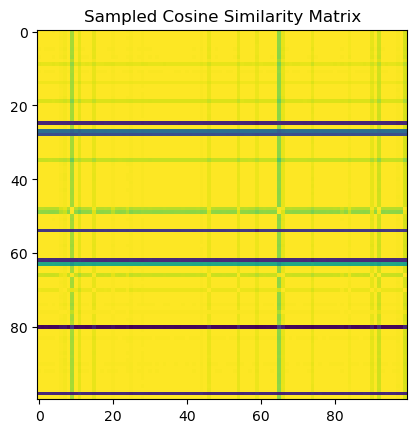

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming similarity_matrix is your cosine similarity matrix
sample_size = 100  # Adjust the sample size as needed
sampled_indices = np.random.choice(similarity_matrix.shape[0], size=sample_size, replace=False)
sampled_matrix = similarity_matrix[sampled_indices][:, sampled_indices]

# Visualize the sampled matrix (you can use seaborn, matplotlib, or any other preferred library)
plt.imshow(sampled_matrix, cmap='viridis')
plt.title('Sampled Cosine Similarity Matrix')
plt.show()

In [24]:
from sklearn.manifold import TSNE
import plotly.express as px

# Assuming similarity_matrix is your cosine similarity matrix
tsne = TSNE(n_components=2, random_state=42)
embedded = tsne.fit_transform(similarity_matrix)

# Create DataFrame for visualization
tsne_df = pd.DataFrame({'X': embedded[:, 0], 'Y': embedded[:, 1]})

# Plot with Plotly
fig = px.scatter(tsne_df, x='X', y='Y', title='t-SNE Visualization of Similarity Matrix')
fig.show()